In [12]:
import mymodel as mm

# Training script (2019 0225 version)

## Data import to PyTorch

In [368]:
# validation set split (n datapoint)
k = 2000 

# Data import to pytorch
y = torch.from_numpy(truncated_labels).float()
x = torch.from_numpy(rolled_stim).float()
#
assert len(y) == len(x), "Data number mismatch."
#
# Add channel dimension for image (x) for convolution operation
x = x.unsqueeze(1)
#
n_cell = y.size(1)
D_stim = x.shape[1:]
print('(ch, dim1, dim2, ...):', D_stim, ' If images are gray scale? ch should be 1.')

# Split data
x = {'train': x[:-k],
       'val': x[-k:]}
y = {'train': y[:-k],
       'val': y[-k:]}
#
dataloaders = {d: DataLoader(TensorDataset(x[d],y[d]), batch_size=32, shuffle=True)
              for d in ['train', 'val']}
dataset_sizes = {d: len(x[d]) for d in ['train', 'val']}

(ch, dim1, dim2, ...): torch.Size([1, 24, 35])  If images are gray scale? ch should be 1.


In [369]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [459]:
import retio as io # custom model save script..
# Global parameters:
    # device
    # dataloaders['train','val']

# 2019 0225 new train function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, coeff_L1=1e-4, model_name='test-model', save='./checkpoints'):
    since = time.time()
    
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts = {key: copy.deepcopy(model.state_dict()) for key in ["train","val"]}
    min_loss = {key: 1e10 for key in ["train","val"]}
    min_dist = {key: 1e10 for key in ["train","val"]}
    #best_acc = 0.0     # validation set evaluation
    
    epoch_loss_log = {key: [] for key in ["train","val"]}
    epoch_dist_log = {key: [] for key in ["train","val"]}
    
    if not os.path.exists(save):
        os.mkdir(save)
    
    fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)
    
        # Each epoch round has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode. .train() in my model??
            else:
                model.eval()   # Set model to evaluate mode. .eval() in my model?? 
            
            # Epoch loss and corrects initialization.
            running_loss = 0.0
            running_dist = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): # Make sure to clear the intermediate values for evaluation.
                    outputs = model(inputs)
                    #_, preds = torch.max(outputs, 1)  # 2nd output? index for max value.
                    
                    dist = criterion(outputs, labels)
                    loss = dist + coeff_L1 * (model.reg_conv1_L1() + model.reg_conv2_L1())
 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # .item() converts tensor to python scalar. 
                running_dist += dist.item() * inputs.size(0) 
                # running_corrects += torch.sum(preds == labels.data) # number of corrects for classification
                        
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_dist = running_dist / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss_log[phase].append(epoch_loss)
            epoch_dist_log[phase].append(epoch_dist)

            #print('{} Loss: {:.4f} Criterion dist: {:.4f}'.format(
            #    phase, epoch_loss, epoch_dist))
            
            # deep copy the model
            # to training set, to validation set
            if epoch_dist < min_dist[phase]:
                min_dist[phase] = epoch_dist
                best_model_wts[phase] = copy.deepcopy(model.state_dict())
                # custom model save script..
                io.save_checkpoint(model, epoch, loss, optimizer, save, model.name+'-'+phase)

        # blank line between epoch result
        print('Epoch {}/{}, Train Loss: {:.4f} Val criterion: {:.4f}'.format(
                epoch, num_epochs-1, epoch_loss_log['train'][-1], epoch_dist_log['val'][-1]))
        #print('{} Loss: {:.4f} Criterion dist: {:.4f}'.format(
        #        phase, epoch_loss, epoch_dist))
        #print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val min dist: {:4f}'.format(min_dist['val']))
    ax[0].plot(epoch_loss_log['train'])
    ax[1].plot(epoch_dist_log['train'])
    ax[2].plot(epoch_dist_log['val'])
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_wts['train'])
    return model, best_model_wts

D_stim : torch.Size([1, 24, 35])
n_cell : 5
Saved!
Saved!
Epoch 0/49, Train Loss: 1.0012 Val criterion: 1.0664
Saved!
Epoch 1/49, Train Loss: 0.9949 Val criterion: 1.0847
Saved!
Epoch 2/49, Train Loss: 0.9891 Val criterion: 1.0730
Saved!
Saved!
Epoch 3/49, Train Loss: 0.9847 Val criterion: 1.0564
Saved!
Saved!
Epoch 4/49, Train Loss: 0.9773 Val criterion: 1.0540
Saved!
Epoch 5/49, Train Loss: 0.9761 Val criterion: 1.0564
Saved!
Epoch 6/49, Train Loss: 0.9757 Val criterion: 1.0555
Saved!
Epoch 7/49, Train Loss: 0.9748 Val criterion: 1.0556
Saved!
Epoch 8/49, Train Loss: 0.9721 Val criterion: 1.0558
Saved!
Epoch 9/49, Train Loss: 0.9713 Val criterion: 1.0625
Saved!
Epoch 10/49, Train Loss: 0.9710 Val criterion: 1.0615
Saved!
Epoch 11/49, Train Loss: 0.9703 Val criterion: 1.0602
Saved!
Epoch 12/49, Train Loss: 0.9690 Val criterion: 1.0591
Saved!
Epoch 13/49, Train Loss: 0.9688 Val criterion: 1.0618
Saved!
Epoch 14/49, Train Loss: 0.9686 Val criterion: 1.0587
Saved!
Epoch 15/49, Train Loss

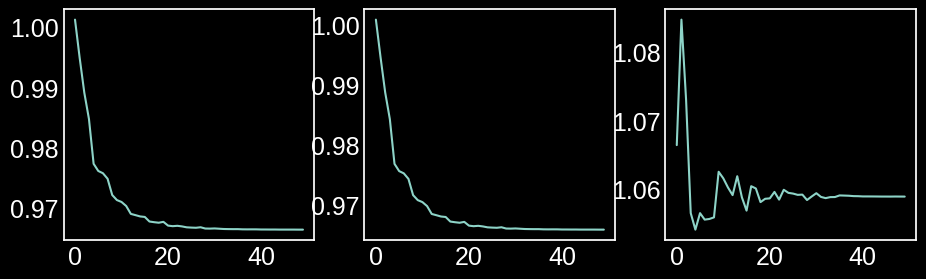

<Figure size 400x100 with 0 Axes>

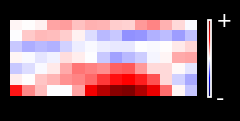

<Figure size 400x1000 with 0 Axes>

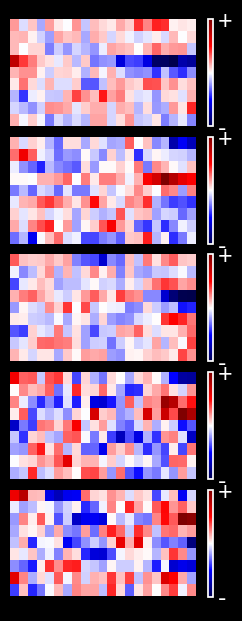

In [462]:
from torch.optim import lr_scheduler
# Model Training
importlib.reload(mm)
importlib.reload(my)
#checkpoint_dir = '/home/juyoung/Modules/1d-whitenoise-models/model-checkpoints/'

### All hyperparameters? -----> Dictionary? and deepcopy for save?
# 1st layer hidden unit filter size
num_types = 1
temporal = 15
spacial = 7
space_stride_ = 2
#
learning_rate = 1e-3
coeff_L1_loss = 1e-4   # encourages to be sparse.
coeff_L2_loss = 1e-2
#
D_stim = x['train'].shape[1:]
n_cell = y['train'].size(1)
print('D_stim :', D_stim)
print('n_cell :', n_cell)
#

#model = mm.LN_TemConv(D_stim, 1, n_cell, temp_filter_size = np.int(0.2 / ifi_upsampled)) # Just tem conv after spatiotemporal pooling/nonlinearity.
model = mm.CNN_2layer(D_stim, num_types, n_cell, temp_filter_size=temporal, space_filter_size=spacial, space_stride=space_stride_)
#model = mm.SimpleModel(D_stim, n_cell)
model = model.to(device)
criterion = nn.MSELoss()

# Data wrapper & optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = coeff_L2_loss)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay = coeff_L2_loss)

# Model Training
best_model, best_model_wts = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50, coeff_L1=coeff_L1_loss)
#model_result, loss_log = train_model_mse_loss(model, loader, optimizer, num_epoch=200, coeff_L1=coeff_L1_loss)

best_model.visualize()

# h5 data loading script

In [7]:
data_dir = '/Users/peterfish/Modules/'
data_dir = '/home/juyoung/Modules/'
#
filename = 'data_filtered_5cells.h5'
filename = 'data_whitenoise_6cells.h5'
filename = 'data_filtered_0205.h5'
filename = 'data_smoothed_5.h5'
#filename = 'data_filtered_0406.h5'

In [8]:
# What keys in the h5?
with h5py.File(data_dir+filename, 'r') as f:
    print(list(f.keys()))
    dset = f['exp1']
    print('Keys  - ', list(dset.keys()))
    print('Attrs - ', list(dset.attrs.keys()))
    print(dset.attrs['Name'])
    #
    rdata = np.array(dset['rdata'])
    rdata_upsampled = np.array(dset['rdata_fliptimes'])
    rtime = np.array(dset['rtime'])
    stim_upsampled = np.array(dset['stim_res'], dtype='f')
    stim_resampled = np.array(dset['stim_rtime'], dtype='f')
    fliptimes = np.array(dset['fliptimes'])
    ifi = np.array(dset.attrs['ifi'])
    print(ifi)

['exp1']
Keys  -  ['fliptimes', 'rdata', 'rdata_fliptimes', 'roi_ids', 'rtime', 'stim_res', 'stim_rtime']
Attrs -  ['Name', 'roi', 'ifi', 'Smooth_size']
b'loc2_whitenoise_1_1 [ch1]'
[0.034403]


# Old training script

In [78]:
#
for epoch in range(num_epoch):
    for x_batch, y_batch in loader:
        
        y_pred = model(x_batch)
        
        # Additional regularization
        L1_loss = 0
        for param in model.parameters():
            L1_loss += param.abs().sum()
            #L1_loss += model.conv2.weight.abs().sum()
        
        loss = nn.functional.mse_loss(y_pred, y_batch) + coeff_L1 * L1_loss
            # Don't need to track intermedicate values.
            # loss = (y_pred - y).pow(2).sum()
        loss.backward() # compute gradient of loss with respect to all model parameters.
        optimizer.step()      # update params. optimizer knows learning_rate
        optimizer.zero_grad() # zero gradient

    if epoch == 1:
        loss_min = loss
        
    # save model
    if loss <= loss_min:
        #torch.save(model.state_dict(), filename+'-epoch-%d'%epoch)
        torch.save(model.state_dict(), filename+'-loss-min')
    
    #print(f'Epoch {epoch} Loss {loss.data}')
    loss_log[epoch] = loss.data
    if epoch % 5 == 0:
        print('Epoch %d  Loss %.4f' % (epoch, loss_log[epoch]))
        ax = plt.subplot(111)
        ax.plot(loss_log)
        plt.show()
        
# Plot loss 
#plt.rcParams['figure.figsize'] = [6, 3];
ax.plot(loss_log)
plt.show()

D_stim : torch.Size([1, 64, 240])
n_cell : 8


KeyboardInterrupt: 